# DFT atom

In [1]:
using Pkg;
Pkg.activate("../../SchrodingerEquationSolver");
include("../src/SchrodingerEquationSolver.jl");
import .SchrodingerEquationSolver as ses
import .ses.Grids as Grids
import .ses.Potentials as Potentials
import .ses.MathUtils as MathUtils
import .ses.Hydrogen as Hydrogen
import .ses.InitialConditions as InitialConditions
import .ses.OneDSchrodingerEquationSolver as odses
import .ses.OneDPoissonEquationSolver as odpes
import .ses.EigenvalueFinders as EigenvalueFinders
import .ses.AtomBasisSet as AtomBasisSet
import .ses.Density as Density
import .ses.ExchangeCorrelation as ExchangeCorrelation
using Plots

  Activating project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver`


In [2]:
#Define parameters and produce an exponential grid.
r_max::Float64=50.0;#Max radius of space grid.
Z::Int64=10;#Atomic number, also used as the charge of coulomb potential.

## Exponential grid

In [3]:


grid_stru= Grids.init_exponential_grid_structure(r_max, Z);
grid= grid_stru.grid;
grid_i= grid_stru.grid_i;
a=grid_stru.a;
b=grid_stru.b;
c_i= (a*b).*(exp.(b.*grid_i));
grid_sqrt= grid.^2.0; 
N= size(grid)[1]; #Number of points in the grid.
print("grid size ", N)

grid size 8057

In [4]:
#Initialization of potentials and energies

#Initializing coulomb potential due to nuclei charge.
V_colu::Vector{Float64}= Potentials.coulomb_potential(Z, grid);
#Initializing Hartree potential due to electron density. 
V_hartree::Vector{Float64}=zeros(Float64, N);
#Initializing exchange potential.
V_x::Vector{Float64}=zeros(Float64, N);
#Initializing correlation potential.
V_c::Vector{Float64}=zeros(Float64, N);
#Initializing energy exchange potential.
E_xp::Vector{Float64}=zeros(Float64, N);
#Initializing energy correlation potential.
E_cp::Vector{Float64}=zeros(Float64, N);
#Initializing exchange + correlation potential.
V_xcp::Vector{Float64}=zeros(Float64, N);
#Initializing the density.
density_in::Vector{Float64}= zeros(Float64, N);
#Initializing total energy
E_total::Float64=1.0;
#Initializing total energy step before
E_total_before::Float64=2.0;
#Initializing energy from energy eigenvalues
E_eigen::Float64=0.0;
#Initializing exchange correlation potential value after integral
V_xc::Float64= 0.0;
#Initializing Hartree energy
E_hartree::Float64= 0.0;
#Initializing exchange energy
E_x::Float64= 0.0;
#Initializing correlation enrgy
E_c::Float64= 0.0;
#Initializing basis set data structure
basis= AtomBasisSet.init_atom_basis_set(Z, grid);

In [5]:
#dev start

In [6]:
for i_orbi in basis.orbitals
    #angular potential for l orbital
    V_angu= Potentials.angular_potential(i_orbi.l, grid);
    #Assemble effective potential.
    V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
    #Energy grid to search for new eigenvalue, search around the previous eigenvalue.
    E_grid= Grids.uniform_grid(i_orbi.E + 0.5*i_orbi.E, i_orbi.E - 0.5*i_orbi.E, 250);
    #Find the energy intervals with potential eigenvalues.
    #E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe,
    #                                                grid,InitialConditions.atom, l=i_orbi.l);

    E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals_v(E_grid, V_effe,
    grid_stru,InitialConditions.atom_v, l=i_orbi.l);

    #Search for a solution to the independent particle Schrodinger equation for the first energy interval, 
    #there should be only one interval. Any other interval would be of a higher energy.
    #u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
    u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder_v(E_intervals[1], V_effe, 
    grid_stru,InitialConditions.atom_v, l=i_orbi.l);
    #Update eigenvalue and eigenfunction in the basis set data structure.
    i_orbi.E=ei_temp;
    i_orbi.u=u_temp;
    E_eigen+= i_orbi.occu*ei_temp;

end

In [7]:
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

1s
-50.000000000000576
2s
-12.500000000003041
2p
-12.500000000002156


In [9]:
density_out= Density.calculate_density(basis);
#Smooth the density with linear mixing (combination) of the previous and current densities.
density_in= Density.linear_mixing(density_in, density_out, alpha=0.25);
#Solve Poisson equation to find the new Hartree potential.
V_hartree= odpes.solver_v_return_V_hartree(Z, density_in, grid_stru);
V_hartree_old= odpes.solver(Z, density_in, grid);

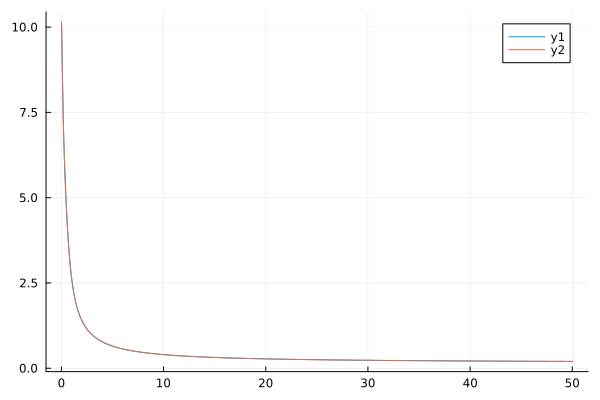

In [10]:
plot(grid_stru.grid, [V_hartree, V_hartree_old])

In [ ]:
#dev end

In [5]:
#Energy minimization loop 
while abs(E_total - E_total_before) > 10.0e-12
    E_eigen=0.0;
    #Loop over every orbital to solve independent particle Schrodinger equation.
    for i_orbi in basis.orbitals
        #angular potential for l orbital
        V_angu= Potentials.angular_potential(i_orbi.l, grid);
        #Assemble effective potential.
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
        #Energy grid to search for new eigenvalue, search around the previous eigenvalue.
        E_grid= Grids.uniform_grid(i_orbi.E + 0.5*i_orbi.E, i_orbi.E - 0.5*i_orbi.E, 300);
        #Find the energy intervals with potential eigenvalues.
        #E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe,
        #                                                grid,InitialConditions.atom, l=i_orbi.l);
        E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals_v(E_grid, V_effe,
        grid_stru,InitialConditions.atom_v, l=i_orbi.l);
        #Search for a solution to the independent particle Schrodinger equation for the first energy interval, 
        #there should be only one interval. Any other interval would be of a higher energy.
        #u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder_v(E_intervals[1], V_effe, 
        grid_stru,InitialConditions.atom_v, l=i_orbi.l);
        #Update eigenvalue and eigenfunction in the basis set data structure.
        i_orbi.E=ei_temp;
        i_orbi.u=u_temp;
        E_eigen+= i_orbi.occu*ei_temp;

    end
    #Update E_total_before from the E_total from the previous step.
    E_total_before= float(E_total);
    #Calculate density with new basis set.
    density_out= Density.calculate_density(basis);
    #Smooth the density with linear mixing (combination) of the previous and current densities.
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.25);
    #Solve Poisson equation to find the new Hartree potential.
    V_hartree= odpes.solver_v_return_V_hartree(Z, density_in, grid_stru);
    #Calculate new exchange and correlation potentials.
    V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
    #Add exchange and correlation potentials.
    V_xcp= V_x .+ V_c;
    #Integrals to calculate energy components.
    V_xc= (4.0*pi)*MathUtils.integral((V_xcp.*density_in.*grid_sqrt.*c_i), grid_i);
    E_hartree= 0.5*(4.0*pi)*(MathUtils.integral((V_hartree.*density_in.*grid_sqrt.*c_i), grid_i));
    E_x= (4.0*pi)*MathUtils.integral((E_xp.*density_in.*grid_sqrt.*c_i), grid_i);
    E_c= (4.0*pi)*MathUtils.integral((E_cp.*density_in.*grid_sqrt.*c_i), grid_i);
    #C_in= (4.0*pi)*MathUtils.integral((density_in.*grid_sqrt), grid)
    #C_out= (4.0*pi)*MathUtils.integral((density_out.*grid_sqrt), grid)
    #Calculate total energy.
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc;
end
println("E_hartree ", E_hartree)
println("E_x + E_c ", (E_x + E_c))
println("E_total ", E_total)
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

E_hartree 65.7299946939333
E_x + E_c -11.710851981999724
E_total -128.23348108583656
1s
-30.30794871904662
2s
-1.3250466696672163
2p
-0.5002451218320517


In [6]:
E_total # Z=2 simple_exponential_grid

-2.8344113631397807

In [6]:
E_total # Z=2 exponential_grid

-2.8348377103009534

In [8]:
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

1s
-0.5726142891819542
